In [1]:
import os
import sys
import cv2
import time
import copy
import math
import shutil
import logging
import numpy as np
import pandas as pd

### Reading all the Img Freq csv files

In [2]:
imgFreq = {}
fList = ['19H','19V','19PCT','22V','37V','37H','37PCT','91H','91V','91PCT','150H','183_1H','183_3H','183_7H']
rList = ['ATL','CPAC','EPAC','IO','SHEM','WPAC']
for r in rList:
    imgFreq[r] = {}
    for f in fList:
        imgFreq[r][f] = pd.read_csv("..\\ImagesPerFreq\\"+r+"_"+f+'.csv')

In [9]:
for r in rList:
    for f in fList:
        print( len( imgFreq[r][f][ imgFreq[r][f].Area > 0.95 ] ) )

1615
1615
1614
1618
1384
1601
1383
1570
1580
1567
1152
1504
1504
1504
255
256
254
251
249
264
249
269
262
262
167
229
229
229
2197
2192
2183
2199
1947
2218
1947
2184
2189
2177
1452
1988
1988
1988
177
177
177
177
151
172
151
168
170
154
123
158
158
158
1678
1676
1673
1697
1535
1702
1535
1671
1679
1669
1242
1560
1560
1560
1832
1831
1830
1831
1606
1824
1606
1789
1797
1787
1234
1641
1641
1641


In [3]:
logging.basicConfig(filename='..\\LogFile\\logFile_cluster_15',level=logging.DEBUG)

In [4]:
import matplotlib.pyplot as plt
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)
from scipy import stats
import scipy
from numpy import zeros, newaxis

class Octants():
    def __init__(self):
        self.o = {}
        
    def Calculate(self, w, ringsize):
        if self.o.get(str(w)+"_"+str(ringsize)) != None:
            return copy.deepcopy(self.o[str(w)+"_"+str(ringsize)])
        print("Calculating Octant")
        #width and height always same
        h=w
        arr = np.zeros((w,h),dtype=np.object)
        sectionArr = np.zeros((w,h), dtype=int)
        for i in range(w):
            for j in range(h):
                arr[i][j] = ( i-int(w/2), j-int(h/2) )
        
        # Creating Sections : We will add all the indices i.e ( (0,0) (1,0).....(n,m) ) to where they belong
        # in the section
        totalRing = len(ringsize)
        section = {}
        for i in range(int(totalRing)):
            section[i] = {}
            for j in range(8):
                section[i][j] = []            
        
        
        t1 = int(w/2)
        for k in range(1, int(totalRing+1) ):
            t2 = int ( ringsize[k-1]/2 )
            newArr = arr[  t1-t2:t1+t2, t1-t2:t1+t2 ]
            
            cenI = int ( newArr.shape[0]/2 )
            cenJ = int ( newArr.shape[1]/2 )
            preRing = int( ringsize[k-2]/2 )
            curRing = t2
            
            for i in range(newArr.shape[0]):
                for j in range(newArr.shape[1]):
                    
                    distance = math.sqrt( ( ( cenI-i)**2 ) + ( (cenJ-j)**2 ) )
                    
                    # Below are the edge cases : Same indices were added in 2 different sections
                    # To resolve I added these two condition
                    if k==totalRing:
                        if distance < preRing:
                            continue
                    elif k==1:
                        if distance>=curRing:
                            continue
                    else:
                        if distance < preRing or distance>=curRing:
                            continue
                    
                    # If above cases doesn't occur then the distance is such that its greater than
                    # previous Ring size and smaller than current Ring size
                    
                    # Once the circle is known we need to find the section where it belongs
                    # Angle helps in determing exactly where the indice belongs
                    angle = math.atan2( newArr[i][j][1], newArr[i][j][0] ) * 180 / np.pi
                    angle+=180
                    angle%=360

                    #Adding it in octants
                    if angle >= 0 and angle < 45:
                        section[k-1][0].append( ( newArr[i,j][0]+int(w/2), newArr[i,j][1]+int(h/2) ) )
                    elif angle >= 45 and angle < 90:
                        section[k-1][1].append( ( newArr[i,j][0]+int(w/2), newArr[i,j][1]+int(h/2) ) )
                    elif angle >= 90 and angle < 135:
                        section[k-1][2].append( ( newArr[i,j][0]+int(w/2), newArr[i,j][1]+int(h/2) ) )
                    elif angle >= 135 and angle < 180:
                        section[k-1][3].append( ( newArr[i,j][0]+int(w/2), newArr[i,j][1]+int(h/2) ) )
                    elif angle >= 180 and angle < 225:
                        section[k-1][4].append( ( newArr[i,j][0]+int(w/2), newArr[i,j][1]+int(h/2) ) )
                    elif angle >= 225 and angle < 270:
                        section[k-1][5].append( ( newArr[i,j][0]+int(w/2), newArr[i,j][1]+int(h/2) ) )
                    elif angle >= 270 and angle < 315:
                        section[k-1][6].append( ( newArr[i,j][0]+int(w/2), newArr[i,j][1]+int(h/2) ) )
                    elif angle >= 315 and angle < 360:
                        section[k-1][7].append( ( newArr[i,j][0]+int(w/2), newArr[i,j][1]+int(h/2) ) )
    
        
        # Assigning Each section a unique number
        app = {}
        totalSection = 0
        for i in range(totalRing):
            app[i] = {}
            for j in range(8):
                if app[i].get(j) == None:
                    app[i][j]=totalSection
                    totalSection+=1
        
        # Each Indices are given a section number where it belongs
        for i in range(totalRing):
            for j in range(8):
                for k in section[i][j]:
                    sectionArr[k[0],k[1]] = int(app[i][j])

        self.o[str(w)+"_"+str(ringsize)] = (sectionArr, totalSection )
        
        return copy.deepcopy(self.o[str(w)+"_"+str(ringsize)])
    
    def Draw(self,w,ringsize):
        if self.o.get(str(w)+"_"+str(ringsize)) != None:
            sectionArr, totalSection = self.o[str(w)+"_"+str(ringsize)]
        else:
            sectionArr, totalSection = self.Calculate( w, ringsize )
        
        #Code to print the maps of octants
        x = {}
        y = {}
        for i in range(w):
            for j in range(w):
                if x.get(sectionArr[i][j]) == None:
                    x[sectionArr[i][j]] = []
                if y.get(sectionArr[i][j]) == None:
                    y[sectionArr[i][j]] = []
                x[sectionArr[i][j]].append(i)
                y[sectionArr[i][j]].append(j)

        for k in range(totalSection):
            plt.scatter(x[k], y[k])
       
                
    def Parameters(self, matrix, w, ringsize, channel):
        if self.o.get(str(w)+"_"+str(ringsize)) != None:
            sectionArr, totalSection = copy.deepcopy(self.o[str(w)+"_"+str(ringsize)])
        else:
            sectionArr, totalSection = self.Calculate( w, ringsize )
        
        param = np.zeros(( totalSection*6*channel ))
        try:
            if channel == 1:
                mainMap = cv2.cvtColor(matrix, cv2.COLOR_BGR2GRAY).flatten()
                sectionArr = sectionArr.flatten()

                t = 0
                for i in range(totalSection):
                    result = np.where(sectionArr == i)
                    miniArr = mainMap[result]
                    param[t] = np.subtract(*np.percentile(miniArr, [75, 25]))
                    param[t+1] = np.mean(miniArr)
                    param[t+2] = np.median(miniArr)
                    param[t+3] = np.std(miniArr) 
                    param[t+4] = np.min(miniArr)
                    param[t+5] = np.max(miniArr)
                    t+=6

            else:
                mainMap = matrix

                t = 0
                for i in range(totalSection):
                    result = np.where(sectionArr == i)
                    miniArr = mainMap[result]
                    for j in range(3):
                        param[t] = np.subtract(*np.percentile(miniArr[:,j], [75, 25]))
                        param[t+1] = np.mean(miniArr[:,j])
                        param[t+2] = np.median(miniArr[:,j])
                        param[t+3] = np.std(miniArr[:,j]) 
                        param[t+4] = np.min(miniArr[:,j])
                        param[t+5] = np.max(miniArr[:,j])
                        t+=6
        except:
            logging.warning("Error in Parameters Function of Octant Class: ", sys.exc_info()[0] )
            
        return param
    
    def CreateImage(self,param_matrix,w,ringsize,channel,t_path,clusterNo):
        if self.o.get(str(w)+"_"+str(ringsize)) != None:
            sectionArr, totalSection = copy.deepcopy(self.o[str(w)+"_"+str(ringsize)])
        else:
            sectionArr, totalSection = self.Calculate( w, ringsize )
        
        statArr = ["IQR", "Mean", "Median", "STD", "Min", "Max"]
        for stat in statArr:
            if os.path.isdir(t_path+stat) == False:
                os.mkdir(t_path+stat)
        try:
            if channel == 1:
                img = np.zeros((w,w))

                for i in range(6):
                    t = i
                    for j in range(totalSection):
                        result = np.where(sectionArr == j)
                        img[result] = param_matrix[t]
                        t+=6
                    img = img.astype(np.uint8)
                    cv2.imwrite(t_path+statArr[i]+"\\cluster_"+str(clusterNo)+".png",img)

            else:
                img = np.zeros((w,w,channel))
                for i in range(6):
                    t = i
                    for j in range(totalSection):
                        result = np.where(sectionArr == j)
                        parameters = []
                        for k in range(3):
                            parameters.append(param_matrix[t])
                            t+=6
                        img[result] = parameters

                    img = img.astype(np.uint8)
                    cv2.imwrite(t_path+statArr[i]+"\\cluster_"+str(clusterNo)+".png",img)
        except:
            logging.warning("Error in CreateImage Function of Octant Class: ", sys.exc_info()[0] )

In [5]:
octa = Octants()

Calculating Octant


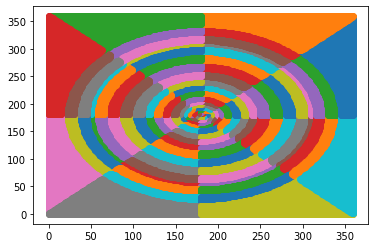

In [6]:
sectionArr, totalSection = octa.Calculate(360,[10,20,30,40,50,60,80,100,120,140,170,200,230,260,270,300,330,361])
octa.Draw(360,[10,20,30,40,50,60,80,100,120,140,170,200,230,260,270,300,330,361])

Calculating Octant


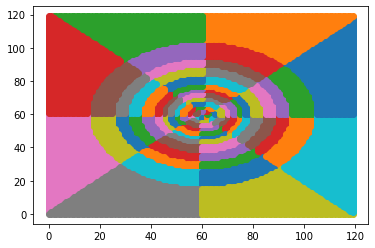

In [7]:
octa.Draw(120,[5,10,15,20,25,30,35,40,50,60,70,90,121])

In [8]:
sectionArr

array([[137, 136, 136, ..., 143, 143, 143],
       [137, 137, 136, ..., 143, 143, 143],
       [137, 137, 137, ..., 143, 143, 142],
       ...,
       [138, 138, 138, ..., 141, 141, 141],
       [138, 138, 139, ..., 140, 141, 141],
       [138, 139, 139, ..., 140, 140, 141]])

In [9]:
class TestDataSelection():
    global octa
    def __init__( self, _df, area, resolution, channel, ringsize, freq, reg ):
        # Consider area according to criteria below
        self.df = _df.loc[_df['Area'] >= area]
        
        self.w = resolution[0]
        self.h = resolution[1]
        self.channel = channel
        self.npmatrixfile = "OctantMatrix_"+reg+"_"+freq+"_"+str(area)+"_"+str(self.w)+"_"+str(channel)+".npy"
        self.ringsize = ringsize
        
    def StartSelection(self):
        if self.ringsize != 0:
            files = [f for f in os.listdir('NumpyFiles\\')]
            if self.npmatrixfile in files:
                return np.load("NumpyFiles\\"+self.npmatrixfile), self.df
            return self.__Octant()
        else:
            return self.__AllPixel()
    
    def __Octant(self):
        print("Checked Octant : ", self.npmatrixfile[13:24])
        section, totalSection = octa.Calculate(self.w, self.ringsize)
        
        # Here instead of considering all pixels we consider statistical value of each sections
        # 8 is the image divided in octants
        # 6 is total statistical values like mean, median, maximum, minimum, standard deviation 
        # and interquartile range for each section
        matOfImages = np.zeros( ( len(self.df), ( self.channel * totalSection * 6 ) ) )
        
        i = 0
        for index, row in self.df.iterrows():
            imgName = row.FileName

            # Read ImageFiles and Not Considering Alpha Value just BGR is considered
            try:
                img_cv = cv2.imread(imgName) 
            except:
                print("Error in reading Image: ",imgName)
            
            try:
                img_cv = cv2.resize(img_cv, (self.w, self.h) )
            except:
                print("Resize Image Error: ",imgName)
            matOfImages[i] = octa.Parameters(img_cv, self.w, self.ringsize, self.channel)
            i+=1
        
        np.save("NumpyFiles\\"+self.npmatrixfile,matOfImages)
        return matOfImages, self.df
    
    def __AllPixel(self):
        # Creating Matrix of Images, each image considers all pixels
        # +2 removed
        matOfImages = np.zeros( ( len(self.df), ( self.channel * self.w * self.h ) ) )

        i = 0
        for index, row in self.df.iterrows():
            imgName = row.FileName

            # Read ImageFiles and Not Considering Alpha Value just BGR is considered
            try:
                img_cv = cv2.imread(imgName) 
            except:
                print("Error in reading Image: ",imgName)
            
            try:
                img_cv = cv2.resize(img_cv, (self.w, self.h) )
            except:
                print("Resize Error: ",imgName)
                
            if self.channel == 1:
                mainMap = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY).flatten()
            else:
                mainMap = img_cv.flatten()

            #alldata = np.append(mainMap, [row[3],row[4]], axis=0)
            matOfImages[i] = mainMap
            i+=1
        
        return matOfImages, self.df

In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)

import numpy as np
import random
import json
import copy
import math

def FuzzySimilarity(x,c):
    #x [ 1, 2 ,3 ,4 ] c[ 0 ,1 ,2 ,3]    
    A = np.minimum(x,c)
    B = np.maximum(x,c)
    return (np.sum(A) + 1) / (np.sum(B) + 2)

class Clustering():
    def __init__(self,x,clusterSize=2,max_iter=300):
        self.Init(x,clusterSize,max_iter)
        
    def Init(self,x, clusterSize, max_iter):
        self.k = int(clusterSize)
        self.m = x.shape[0]
        self.p = x.shape[1]
        self.x = x
        max_x = np.amax(self.x, axis=0)
        max_x[max_x == 0] = 1
        self.norm_x = self.x / max_x
        self.max_iter = max_iter
        self.n_iter = 0
        self.labels = []
        self.cluster_centers = np.zeros((self.k,self.p))

    def Fuzzy_K_Means(self,w1=1.0,w2=1.0,w3=1.0):
        prevC = np.random.rand(self.k,self.p)
        rand_center_index = random.sample(range(0, self.m), self.k)
        
        # Randomly assigning each cluster center
        # a unique x (whose index lies from 0 to m)
        for j in range(self.k):
            self.cluster_centers[j,:] = self.norm_x[rand_center_index[j],:] 
        
        for i in range(self.m):
            self.labels.append(0)

        isConverged = False
        while not isConverged and self.n_iter<self.max_iter:
            #Assigning each images to cluster where it belongs 
            for i in range(self.m):    
                maxSimilarity = -math.inf
                index = -1
                for j in range(self.k):
                    #Calculating Similarity for Image, Pressure and Wind
                    #s1 = FuzzySimilarity(self.norm_x[i,0:self.p-2],self.cluster_centers[j,0:self.p-2])
                    #s2 = FuzzySimilarity(self.norm_x[i,self.p-2:self.p-1],self.cluster_centers[j,self.p-2:self.p-1])
                    #s3 = FuzzySimilarity(self.norm_x[i,self.p-1:self.p],self.cluster_centers[j,self.p-1:self.p])
                    #fs = ( (w1*s1) + (w2*s2) + (w3*s3) ) / (w1+w2+w3)
                    fs = FuzzySimilarity(self.norm_x[i,:],self.cluster_centers[j,:])
                    if maxSimilarity < fs:
                        maxSimilarity = fs
                        index = j

                # Assigning cluster(1...k) to each images based on MaxSimilarity value
                self.labels[i] = index


            # Iterating through each images
            # Each labels determine unique cluster, images are assigned to
            total = np.zeros((self.k,self.p+1))
            for i in range(self.m):
                total[self.labels[i],0] += 1 
                total[self.labels[i],1:] += self.norm_x[i,:]

            # Updating cluster center            
            for j in range(self.k):
                self.cluster_centers[j,:] = total[j,1:]/ (total[j,0])
                
            if np.array_equal(prevC, self.cluster_centers):
                isConverged = True

            self.n_iter+=1     
            prevC = copy.deepcopy(self.cluster_centers)
            
        self.cluster_centers *= np.amax(self.x, axis=0)
        self.silhouetteAvg = silhouette_score(self.x, self.labels)
        self.silhouetteValues = silhouette_samples(self.x, self.labels)
    
    def Scikit_K_Means(self):
        kmeans = KMeans(n_clusters=self.k,max_iter=self.max_iter).fit(self.x)
        self.cluster_centers = kmeans.cluster_centers_
        self.n_iter = kmeans.n_iter_
        self.labels = kmeans.labels_
        self.silhouetteAvg = silhouette_score(self.x, self.labels)
        self.silhouetteValues = silhouette_samples(self.x, self.labels)
        
    def __fancy_dendrogram(self, *args, **kwargs):
        max_d = kwargs.pop('max_d', None)
        if max_d and 'color_threshold' not in kwargs:
            kwargs['color_threshold'] = max_d
        annotate_above = kwargs.pop('annotate_above', 0)

        ddata = dendrogram(*args, **kwargs)

        if not kwargs.get('no_plot', False):
            plt.title('Hierarchical Clustering Dendrogram (truncated)',fontsize=16)
            plt.xlabel('Cluster Size',fontsize=14)
            plt.ylabel('Distance',fontsize=14)
            for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
                x = 0.5 * sum(i[1:3])
                y = d[1]
                if y > annotate_above:
                    plt.plot(x, y, 'o', c=c)
                    plt.annotate("%0.3g" % y, (x, y), xytext=(0, -5),
                                 textcoords='offset points',
                                 va='top', ha='center')
            if max_d:
                plt.axhline(y=max_d, c='k')
        return ddata
    
    
    def Scipy_Agglomerative(self, dist_m, link_m, df, path):
        Z = linkage(self.x,method=link_m,metric=dist_m)
        
        for cluster_k in range(self.k,9,-1):
            new_path = path + str(cluster_k) + "\\"
            
            if os.path.isdir(new_path):
                continue
            
            os.mkdir(new_path)
            
            copy_Z = copy.deepcopy(Z)
            label_ans = fcluster(copy_Z, t=cluster_k, criterion='maxclust')
            fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(30,15))

            dn = self.__fancy_dendrogram(Z, 
                            labels=label_ans, 
                            ax=axes, 
                            truncate_mode='lastp', 
                            p=cluster_k,
                            orientation='top',
                            get_leaves = True,
                            annotate_above=10,
                            show_leaf_counts = True,
                            leaf_rotation = 90,
                            leaf_font_size = 20
                           )
            '''
            try:
                with open(new_path+"dendogram_lastp_"+str(cluster_k)+".json", 'w') as f:
                    json.dump(dn, f, default=convert)
            except TypeError as e:
                logging.error(new_path+"dendogram_lastp_"+str(cluster_k)+".json not created"+str(e))
            '''
            
            plt.savefig(new_path+"dendrogram_lastp_"+str(cluster_k)+".png",format="png")

            #dn = dendrogram(Z, labels=label_ans, ax=axes, truncate_mode='level', p=i, orientation='top')
            #plt.savefig(path+"dendrogram_level_"+str(i)+".png",format="png")

            plt.close('all')
            
            self.labels = label_ans
            self.labels = [x - 1 for x in self.labels]
            self.silhouetteAvg = silhouette_score(self.x, self.labels)
            self.silhouetteValues = silhouette_samples(self.x, self.labels)

            #Create CSV with Image, ClusterLabel and Silhouette value
            image = pd.DataFrame({ 'FileName':df.FileName, 'ClusterLabel':self.labels, 'SilhouetteVal':self.silhouetteValues, 'T_No':df.T_No}) 
            image.to_csv(new_path+"testInfo.csv",index = False)
            
            del copy_Z

In [12]:
from ast import literal_eval
class TestCases:
    global octa
    def __init__(self):
        self.testMethods = {}
        self.testMethods["agglo"] = pd.read_csv('..\\testcases\\agglo.csv')
        self.testMethods["kmeans"] = pd.read_csv('..\\testcases\\kmeans.csv')
        self.testMethods["fuzzykmeans"] = pd.read_csv('..\\testcases\\fuzzykmeans.csv')
        for k,v in self.testMethods.items():
            self.testMethods[k].ResolutionX = self.testMethods[k].ResolutionX.astype(int)
            self.testMethods[k].ResolutionY = self.testMethods[k].ResolutionY.astype(int)
            self.testMethods[k].Channel = self.testMethods[k].Channel.astype(int)
            self.testMethods[k].ClusterSize = self.testMethods[k].ClusterSize.astype(int)
            self.testMethods[k].MaxIter = self.testMethods[k].MaxIter.astype(int)
            self.testMethods[k].RingSize = self.testMethods[k].RingSize.apply(literal_eval)
            
    def RunTestCase(self, k,_df, test, t_path,freq,reg):
        start_1 = time.time()
        tds = TestDataSelection(_df,
                                test.Area, 
                                (test.ResolutionX,test.ResolutionY),
                                test.Channel,
                                test.RingSize,
                                freq,
                                reg
                               )
        
        matrix, df = tds.StartSelection()
        end_1 = time.time()
        logging.debug("Time taken for Data Selection: " + str((end_1-start_1)/60) + " min")
        
        
        cL = Clustering(matrix,
                        test.ClusterSize,
                        test.MaxIter
                       )
        
        if k == "agglo":
            start_2 = time.time()
            cL.Scipy_Agglomerative(test.DistanceMetric,
                                   test.Linkage,
                                   df,
                                   t_path
                                  )      
            end_2 = time.time()
            logging.debug("Average silhouette score for "+str(cL.k)+" cluster : "+str(cL.silhouetteAvg) )
            logging.debug("Time taken by Clustering Algorithm: " + str((end_2-start_2)/60) + " min")
        
        else:
            for clust_size in range( 10,int(test.ClusterSize)+1 ):
                start_2 = time.time()
                
                cluster_t_path = t_path + str(clust_size) + "\\"
                if os.path.isdir(cluster_t_path):
                    continue
                os.mkdir(cluster_t_path)
                
                cL.k = clust_size
                if k == "kmeans":
                    cL.Scikit_K_Means()
                    
                elif k == "fuzzykmeans":
                    cL.Init(matrix,
                        test.ClusterSize,
                        test.MaxIter
                       )
                    cL.Fuzzy_K_Means(test.ImageWeight,
                                 test.PressureWeight,
                                 test.WindWeight
                                )
                                
                # Creating K cluster folders
                # Creating Images for according to cluster centers
                for i in range(clust_size):
                    img = cL.cluster_centers[i,0 : ( test.Channel * test.ResolutionX * test.ResolutionY ) ]

                    if test.RingSize != 0:
                        octa.CreateImage(img, 
                                         test.ResolutionX,
                                         test.RingSize,
                                         test.Channel,
                                         cluster_t_path,
                                         i)
                    else:
                        if test.Channel == 1:
                            img = img.reshape(test.ResolutionX,test.ResolutionY)
                        else:
                            img = img.reshape(test.ResolutionX,test.ResolutionY,3)
                        img = img.astype(np.uint8)
                        cv2.imwrite(cluster_t_path+"cluster_"+str(i)+".png",img)
                
                #Create CSV with Image, ClusterLabel and Silhouette value
                image = pd.DataFrame({ 'FileName':df.FileName, 'ClusterLabel':cL.labels, 'SilhouetteVal':cL.silhouetteValues, 'T_No':df.T_No}) 
                image.to_csv(cluster_t_path+"testInfo.csv",index = False)
            
                end_2 = time.time()
                logging.debug("Average silhouette score for "+str(cL.k)+" cluster : "+str(cL.silhouetteAvg) )
                logging.debug("Time taken by Clustering Algorithm: " + str((end_2-start_2)/60) + " min\n")

    def RunTests(self,_df,region,freq):
        for k,test in self.testMethods.items():
            path = "E:\\AllFrequencies\\"+region+"\\"+freq+"\\"+k+"\\"
            
            if os.path.isdir(path) == False:
                os.mkdir(path)
            print(path)
            
            if k != "agglo":
                for case in range(len(test)):
                    #testnumber = int(test.TestNo.iloc[case][5:])
                    #if  testnumber == 34 or testnumber==35:
                    start_1 = time.time()

                    # Creating a Test Directory
                    t_path = path + test.TestNo.iloc[case]

                    if os.path.isdir(t_path):
                        continue
                    os.mkdir(t_path)
                    t_path+="\\"

                    logging.debug("Path for this Test Case:- "+t_path)

                    self.RunTestCase(k,_df,test.iloc[case],t_path,freq,region)

                    logging.debug("Time taken -> "+region+" "+freq+" "+k+" "+test.TestNo.iloc[case]+" : "+str((time.time()-start_1)/60) + " min\n")

In [13]:
test = TestCases()
for region,v1 in imgFreq.items():
    for freq, _df in v1.items():
        test.RunTests(_df,region,freq)

E:\AllFrequencies\ATL\19H\agglo\
E:\AllFrequencies\ATL\19H\kmeans\
E:\AllFrequencies\ATL\19H\fuzzykmeans\
E:\AllFrequencies\ATL\19V\agglo\
E:\AllFrequencies\ATL\19V\kmeans\
E:\AllFrequencies\ATL\19V\fuzzykmeans\
E:\AllFrequencies\ATL\19PCT\agglo\
E:\AllFrequencies\ATL\19PCT\kmeans\
E:\AllFrequencies\ATL\19PCT\fuzzykmeans\
E:\AllFrequencies\ATL\22V\agglo\
E:\AllFrequencies\ATL\22V\kmeans\
E:\AllFrequencies\ATL\22V\fuzzykmeans\
E:\AllFrequencies\ATL\37V\agglo\
E:\AllFrequencies\ATL\37V\kmeans\
E:\AllFrequencies\ATL\37V\fuzzykmeans\
E:\AllFrequencies\ATL\37H\agglo\
E:\AllFrequencies\ATL\37H\kmeans\
E:\AllFrequencies\ATL\37H\fuzzykmeans\
E:\AllFrequencies\ATL\37PCT\agglo\
E:\AllFrequencies\ATL\37PCT\kmeans\
E:\AllFrequencies\ATL\37PCT\fuzzykmeans\
E:\AllFrequencies\ATL\91H\agglo\
E:\AllFrequencies\ATL\91H\kmeans\
E:\AllFrequencies\ATL\91H\fuzzykmeans\
E:\AllFrequencies\ATL\91V\agglo\
E:\AllFrequencies\ATL\91V\kmeans\
E:\AllFrequencies\ATL\91V\fuzzykmeans\
E:\AllFrequencies\ATL\91PCT\agglo\

E:\AllFrequencies\WPAC\37PCT\agglo\
E:\AllFrequencies\WPAC\37PCT\kmeans\
E:\AllFrequencies\WPAC\37PCT\fuzzykmeans\
E:\AllFrequencies\WPAC\91H\agglo\
E:\AllFrequencies\WPAC\91H\kmeans\
E:\AllFrequencies\WPAC\91H\fuzzykmeans\
E:\AllFrequencies\WPAC\91V\agglo\
E:\AllFrequencies\WPAC\91V\kmeans\
E:\AllFrequencies\WPAC\91V\fuzzykmeans\
E:\AllFrequencies\WPAC\91PCT\agglo\
E:\AllFrequencies\WPAC\91PCT\kmeans\
E:\AllFrequencies\WPAC\91PCT\fuzzykmeans\
E:\AllFrequencies\WPAC\150H\agglo\
E:\AllFrequencies\WPAC\150H\kmeans\
E:\AllFrequencies\WPAC\150H\fuzzykmeans\
E:\AllFrequencies\WPAC\183_1H\agglo\
E:\AllFrequencies\WPAC\183_1H\kmeans\
E:\AllFrequencies\WPAC\183_1H\fuzzykmeans\
E:\AllFrequencies\WPAC\183_3H\agglo\
E:\AllFrequencies\WPAC\183_3H\kmeans\
E:\AllFrequencies\WPAC\183_3H\fuzzykmeans\
E:\AllFrequencies\WPAC\183_7H\agglo\
E:\AllFrequencies\WPAC\183_7H\kmeans\
E:\AllFrequencies\WPAC\183_7H\fuzzykmeans\


### Extra Code

In [ ]:
r = 'ATL'
f = '19H'
imgFreq[r][f].FileName.iloc[0]

In [ ]:
test.RunTests(imgFreq['ATL']['91V'], 'ATL', '91V' )

In [ ]:
type ( app.iloc[9] )

In [ ]:
app =  test.testMethods["agglo"].RingSize.apply(literal_eval)

In [ ]:
region = 'ATL'
freq = '91V'
k = 'agglo'
case = 7

path = "..\\..\\AllFrequencies\\"+region+"\\"+freq+"\\"+k+"\\"
t_path = path +"Test_"+str(case)
if os.path.isdir(t_path):
    continue
os.mkdir(t_path)
t_path+="\\"
_df

self.RunTestCase(k,_df,test.iloc[case],t_path)

In [ ]:
import os
files = [f for f in os.listdir('NumpyFiles\\') if os.path.isfile(f)]
print(files)

In [ ]:
stats.tstd(b)asdsa

In [ ]:
                if os.path.isdir(t_path):
                    continue
                os.mkdir(t_path)
                    
                
            
            
            
                #cL = Clustering(matrix,
                #        clust_size,
                #        test.MaxIter
                #       )
                
                #cL.Scikit_K_Means()
                
                newPath = 
                
                


                #os.mkdir(t_path+str(i))


                
            
        
        elif k == "fuzzykmeans":
            
            


In [ ]:
v.std()